# Chart of weeks taken and accuracy

Here we'll take a varying amount of weeks to train the model and note the accuracy of the model. The result will be a chart mentioned in the title.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as plt
import sys
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

sb.set_style('dark')
plt.rcParams['figure.figsize'] = (14,10)

In [2]:
sys.path.append('../scripts/')
import helpers_models as hm

We'll be using the helpers which encapsulate common procedures from previous notebooks. These are used to load and process the dataset.

In [3]:
data = hm.load_pivot_numbers()

In [4]:
first_week = data['tweets'].columns.min()
target_week = data['tweets'].columns.max()

In [5]:
data = hm.make_target(data, target_week)

In [6]:
data = hm.balance_data(data)

In [7]:
data_input = data.drop('target', axis=1)
data_target = data['target']

In [8]:
data_input_norm = hm.normalize_data(data_input)

In [9]:
data_input_decay = hm.apply_time_decay(data_input, first_week, target_week)

In [10]:
data_input_norm_decay = hm.apply_time_decay(data_input_norm, first_week, target_week)

The following part is a quirky one. We need to convert the `data_target` to a data frame and set multiindex columns. This should not flatten the columns on `data_input` when concatenating.

In [11]:
data_target = pd.DataFrame(data_target)

In [12]:
data_target.columns = pd.MultiIndex.from_tuples([(c, target_week) for c in data_target])

In [13]:
data = pd.concat([data_input, data_target], axis=1)
data_norm = pd.concat([data_input_norm, data_target], axis=1)
data_decay = pd.concat([data_input_decay, data_target], axis=1)
data_norm_decay = pd.concat([data_input_norm_decay, data_target], axis=1)

Now it's time to produce the chart. First, we'll make a for loop with the starting week moving from the first to the last - 1 (so we'll take at least one week as an input to the model).

In [14]:
chart_data = pd.DataFrame()

In [15]:
%%time
for starting_week in range(first_week, target_week):
    print()
    print('TRAINING starting week', starting_week)
    
    my_data = data
    my_data_norm = data_norm
    my_data_decay = data_decay
    my_data_norm_decay = data_norm_decay
    
    # drop weeks before starting week
    for week in range(first_week, starting_week):
        print('dropping week', week)
        my_data = my_data.drop(week, axis=1, level=1)
        my_data_norm = my_data_norm.drop(week, axis=1, level=1)
        my_data_decay = my_data_decay.drop(week, axis=1, level=1)
        my_data_norm_decay = my_data_norm_decay.drop(week, axis=1, level=1)
    
    models = [
        my_data,
        my_data_norm,
        my_data_decay,
        my_data_norm_decay,
    ]
    
    # for each dataset, train a model and note accuracy
    def train_model(current_data):
    
        # train a model
        train, train_target, test, test_target = hm.split_train_test(current_data)
        reg = LogisticRegressionCV()

        print('fitting')
        model = reg.fit(train, train_target)

        # note the accuracy
        print('scoring')
        return accuracy_score(test_target, model.predict(test))
    
    models = list(map(train_model, models))
    
    # insert models into the chart data frame
    row = {
        'weeks taken': target_week - starting_week,
        'base': models[0],
        'normalized': models[1],
        'with time decay': models[2],
        'normalized with time decay': models[3]
    }
    chart_data = chart_data.append(row, ignore_index=True)


TRAINING starting week 23


../scripts/helpers_models.py:64: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  train = data[train_rows].drop('target', axis=1)
../scripts/helpers_models.py:66: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  test = data[~train_rows].drop('target', axis=1)


fitting


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


scoring
fitting
scoring
fitting
scoring
fitting
scoring

TRAINING starting week 24
dropping week 23
fitting
scoring
fitting
scoring
fitting
scoring
fitting
scoring

TRAINING starting week 25
dropping week 23
dropping week 24
fitting
scoring
fitting
scoring
fitting
scoring
fitting
scoring

TRAINING starting week 26
dropping week 23
dropping week 24
dropping week 25
fitting
scoring
fitting
scoring
fitting
scoring
fitting
scoring

TRAINING starting week 27
dropping week 23
dropping week 24
dropping week 25
dropping week 26
fitting
scoring
fitting
scoring
fitting
scoring
fitting
scoring

TRAINING starting week 28
dropping week 23
dropping week 24
dropping week 25
dropping week 26
dropping week 27
fitting
scoring
fitting
scoring
fitting
scoring
fitting
scoring

TRAINING starting week 29
dropping week 23
dropping week 24
dropping week 25
dropping week 26
dropping week 27
dropping week 28
fitting
scoring
fitting
scoring
fitting
scoring
fitting
scoring

TRAINING starting week 30
dropping week 

Now we print the chart.

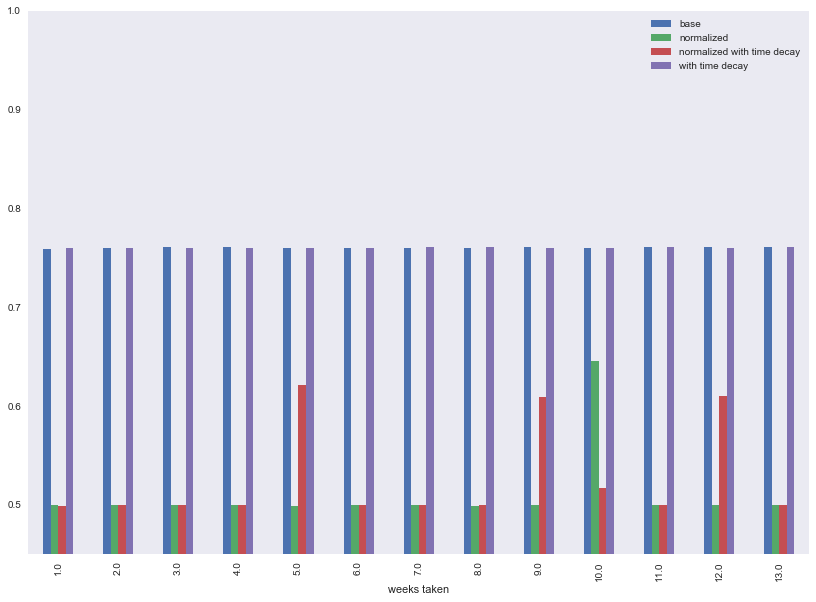

In [19]:
chart_data.set_index('weeks taken').sort_index().plot(kind='bar', ylim=(0.45, 1))

Let's now see what model has the best accuracy.

In [17]:
best_per_column = chart_data.drop('weeks taken', axis=1).max()
best_per_column.idxmax()

'base'

In [18]:
best_of_best = chart_data[best_per_column.idxmax()].idxmax()
chart_data.loc[best_of_best]['weeks taken']

11.0

In [22]:
13 - chart_data.drop('weeks taken', axis=1).idxmax()

base                          11
normalized                    10
normalized with time decay     5
with time decay               13
dtype: int64

In [21]:
chart_data

,base,normalized,normalized with time decay,weeks taken,with time decay
0,0.760436,0.499977,0.499402,13.0,0.761196
1,0.760655,0.499588,0.610147,12.0,0.760078
2,0.761265,0.499617,0.499515,11.0,0.760514
3,0.760081,0.645913,0.516917,10.0,0.759554
4,0.760800,0.499953,0.609212,9.0,0.759894
5,0.760024,0.499226,0.499438,8.0,0.760590
6,0.759912,0.499469,0.499698,7.0,0.760635
7,0.759810,0.499556,0.499778,6.0,0.760120
8,0.760301,0.499352,0.621555,5.0,0.759902
9,0.761075,0.499908,0.499540,4.0,0.760300
